# Load SuperPoint Model

In [12]:
#from transformers import AutoImageProcessor, SuperPointForKeypointDetection, SuperPointConfig
import torch
from PIL import Image
from tqdm import tqdm
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import BallTree
from superpoint import SuperPoint
import cv2
import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# configuration = SuperPointConfig(max_keypoints=60)
# processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
# model = SuperPointForKeypointDetection(configuration)

In [2]:
def superpoint(image, model):
    image = torch.as_tensor(image).float() #Convert np array to torch tensor
    image = image.unsqueeze(0).unsqueeze(0).to(device) #Resize the input data for [H,W] to [1,1,H,W]
    model.eval()
    #_, inp = read_image(img, device)
    pred = model({'image': image}) #run model inference
    des = pred['descriptors'][0] #split the descriptor from the output
    des = torch.transpose(des, 0, 1)
    des = des.cpu().detach().numpy()
    des = des.astype(np.float64)
    return des
config = {}
model = SuperPoint(config).to(device)

Loaded SuperPoint model


/home/jeremy/Perception/superpoint.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)))


# Compute SuperPoint Descriptors

In [14]:

base_path =r'./images_subsample'
query_path=r'./query_test'
image_descriptors = []
database_name = []
for i in tqdm(os.listdir(base_path)):
    
    #image = Image.open(os.path.join(base_path,i))
    image = cv2.imread(os.path.join(base_path,i),cv2.IMREAD_GRAYSCALE) / 255
    #inputs = processor(image, return_tensors="pt").to(device)
    # outputs = model(**inputs)
    descriptor = superpoint(image,model)
    # image_descriptors.append(outputs.descriptors.detach().numpy().squeeze())
    image_descriptors.append(descriptor)
    database_name.append(i)

100%|██████████████████████████████████████| 3645/3645 [00:04<00:00, 758.70it/s]


In [5]:
print(image_descriptors[0].shape)
print(image_descriptors[1].shape)
print(image_descriptors[2].shape)

(163, 256)
(138, 256)
(127, 256)


### From above: the Output of SuperPoint Descriptors are inhomogeneous
### So, make them homogeneous by capping descriptor length at 700

In [16]:
max_descriptors = 700
processed_descriptors = list()
for desc in image_descriptors:
    processed_descriptors.extend(desc[:max_descriptors])

In [ ]:
# Display one capped descriptor
print(processed_descriptors[0],processed_descriptors[0].shape)

# Compute Visual Dictionary

In [21]:
import joblib
codebook = MiniBatchKMeans(n_clusters = 32, init='k-means++', n_init=1, verbose=1).fit(processed_descriptors)
joblib.dump(codebook, 'codebook.pkl')

Init 1/1 with method k-means++
Inertia for init 1/1: 3359.542827843464
Minibatch step 1/53632: mean batch inertia: 1.100413109375218
Minibatch step 2/53632: mean batch inertia: 0.7325759127391327, ewa inertia: 0.7325759127391327
Minibatch step 3/53632: mean batch inertia: 0.7132865008207224, ewa inertia: 0.7325039816179625
Minibatch step 4/53632: mean batch inertia: 0.6979180375571101, ewa inertia: 0.7323750090114595
Minibatch step 5/53632: mean batch inertia: 0.7007611147820269, ewa inertia: 0.7322571193180827
Minibatch step 6/53632: mean batch inertia: 0.7105112125136379, ewa inertia: 0.7321760278123425
Minibatch step 7/53632: mean batch inertia: 0.7060483018200969, ewa inertia: 0.732078596297468
Minibatch step 8/53632: mean batch inertia: 0.7029764525435418, ewa inertia: 0.7319700730393442
Minibatch step 9/53632: mean batch inertia: 0.7022172828762144, ewa inertia: 0.7318591234902638
Minibatch step 10/53632: mean batch inertia: 0.683926965457483, ewa inertia: 0.7316803822263005
Mini

['codebook.pkl']

# Compute VLAD Referenced from https://github.com/IrvingF7/VPR_VLAD/blob/master/VPR_VLAD%2BSuperpoint.ipynb

In [6]:
def get_VLAD(X, codebook):

    predictedLabels = codebook.predict(X)
    centroids = codebook.cluster_centers_
    labels = codebook.labels_
    k = codebook.n_clusters
   
    m,d = X.shape
    VLAD_feature = np.zeros([k,d])
    #computing the differences

    # for all the clusters (visual words)
    for i in range(k):
        # if there is at least one descriptor in that cluster
        if np.sum(predictedLabels == i) > 0:
            # add the diferences
            VLAD_feature[i] = np.sum(X[predictedLabels==i,:] - centroids[i],axis=0)
    

    VLAD_feature = VLAD_feature.flatten()
    # power normalization, also called square-rooting normalization
    VLAD_feature = np.sign(VLAD_feature)*np.sqrt(np.abs(VLAD_feature))

    # L2 normalization
    VLAD_feature = VLAD_feature/np.linalg.norm(VLAD_feature)
    return VLAD_feature

In [24]:
database_VLAD = []
for i in tqdm(os.listdir(base_path)):
    image = cv2.imread(os.path.join(base_path,i),cv2.IMREAD_GRAYSCALE) / 255
    descriptor = superpoint(image,model)
    VLAD = get_VLAD(descriptor, codebook)
    database_VLAD.append(VLAD)
    database_name.append(i)
database_VLAD = np.asarray(database_VLAD)
print(database_VLAD.shape)

100%|██████████████████████████████████████| 3645/3645 [00:10<00:00, 363.17it/s]

(3645, 8192)


In [25]:
tree = BallTree(database_VLAD, leaf_size=30) # was 60

In [26]:
import joblib
joblib.dump(tree, 'ball_tree.pkl')

['ball_tree.pkl']

In [27]:
joblib.dump(database_VLAD, 'database_VLAD.pkl')

['database_VLAD.pkl']

In [28]:
joblib.dump(database_name, 'database_name.pkl')

['database_name.pkl']

In [9]:
value_list = []
for i in tqdm(os.listdir(query_path)):
    image = cv2.imread(os.path.join(query_path,i),cv2.IMREAD_GRAYSCALE) / 255
    descriptor = superpoint(image,model)
    VLAD_query = get_VLAD(descriptor, codebook).reshape(1, -1)
    dist, index = tree.query(VLAD_query, 4)
    print(index) # this is tree index not the image index
    # index is an array of array of 1
    for j in range(len(index[0])):
        value_name = database_name[index[0][j]]
        print(value_name)
        value_list.append(value_name)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 80.38it/s]

[[ 281 2301  692  563]]
198.jpg
199.jpg
641.jpg
197.jpg
[[ 617  587 1885 2325]]
3650.jpg
19.jpg
20.jpg
3649.jpg
[[ 718 2868 1314 2080]]
15.jpg
14.jpg
3654.jpg
16.jpg
[[ 931 2899  320 1344]]
506.jpg
508.jpg
507.jpg
509.jpg
[[ 975 2697 3502  935]]
126.jpg
125.jpg
124.jpg
127.jpg
[[1224  276   94  285]]
3524.jpg
3523.jpg
3522.jpg
3521.jpg
[[2649 2306   53 2418]]
1769.jpg
1768.jpg
1770.jpg
1771.jpg
[[3358  369 1052 1792]]
592.jpg
593.jpg
594.jpg
595.jpg
[[3493 2931 1148 1993]]
3079.jpg
3078.jpg
3080.jpg
3081.jpg


In [10]:
print(value_list)

['198.jpg', '199.jpg', '641.jpg', '197.jpg', '3650.jpg', '19.jpg', '20.jpg', '3649.jpg', '15.jpg', '14.jpg', '3654.jpg', '16.jpg', '506.jpg', '508.jpg', '507.jpg', '509.jpg', '126.jpg', '125.jpg', '124.jpg', '127.jpg', '3524.jpg', '3523.jpg', '3522.jpg', '3521.jpg', '1769.jpg', '1768.jpg', '1770.jpg', '1771.jpg', '592.jpg', '593.jpg', '594.jpg', '595.jpg', '3079.jpg', '3078.jpg', '3080.jpg', '3081.jpg']


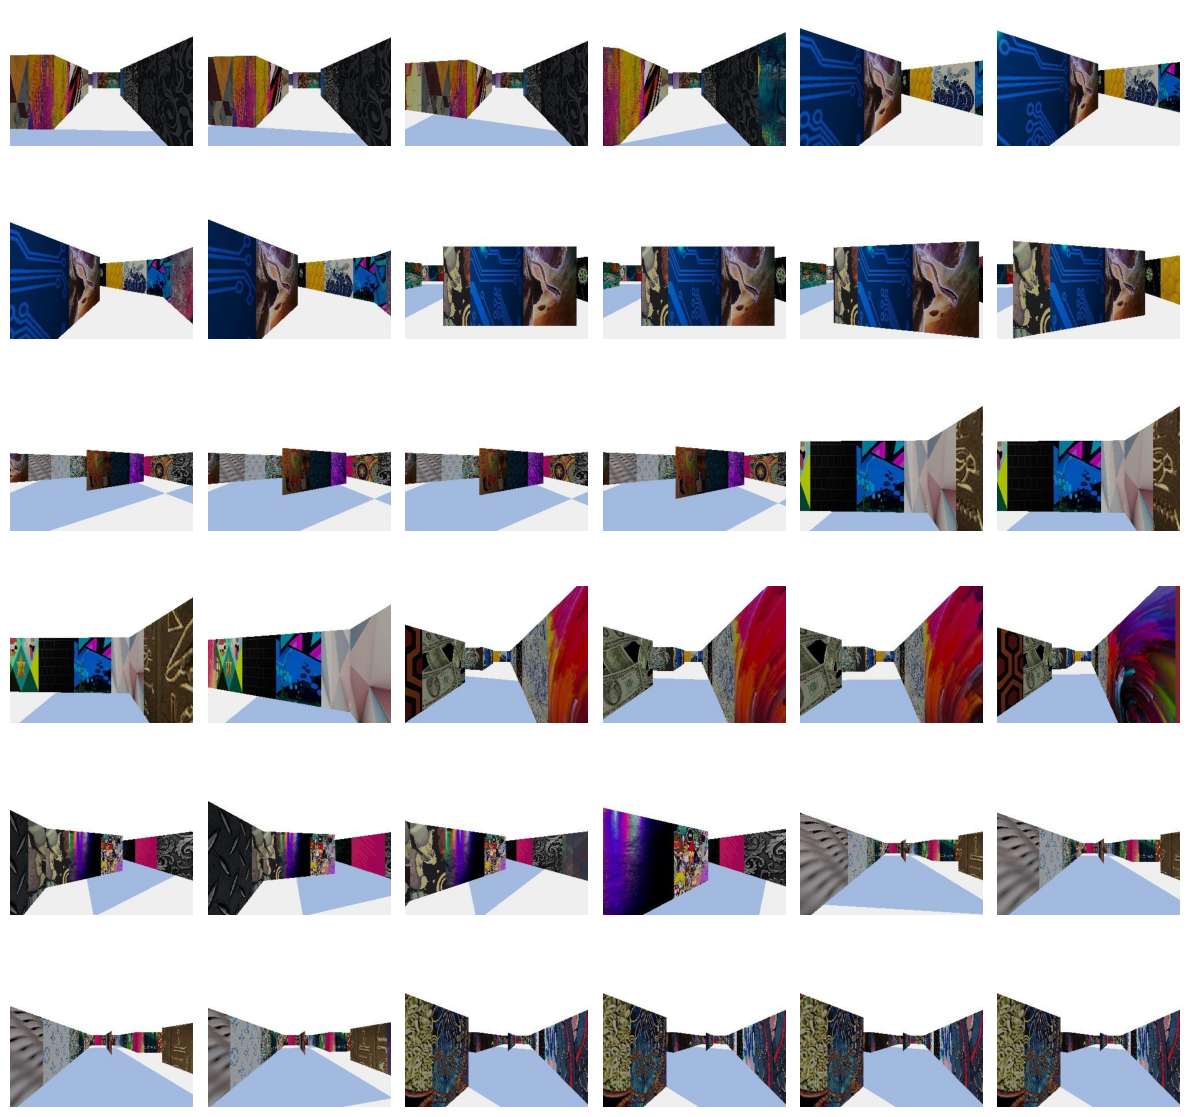

In [13]:
num_images = len(value_list)
rows = int(np.ceil(np.sqrt(num_images)))
cols = int(np.ceil(num_images / rows))

fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.flatten() if num_images > 1 else [axs]

for i in range(num_images):
    match_0 = cv2.imread(os.path.join(base_path, value_list[i]))
    match_0 = cv2.cvtColor(match_0, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    axs[i].imshow(match_0)
    axs[i].axis('off')  # Remove axes

# Remove extra subplots if any
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()